In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.rcParams["font.family"] = "Tahoma"

In [2]:
# Parameters for plotting
n_classes = 2
plot_colors = "ryb"
plot_step = 0.02

In [3]:
# Load data

lit_df = pd.read_csv('./data/bfo_lit_df_modeling_mmvi_20221019.csv')
#lit_df = lit_df.sample(frac=1).reset_index(drop=True)

# WARNING: EDIT THIS (among other things)
lit_df = lit_df.fillna(0)

lit_features_df = lit_df.drop(['Unnamed: 0', 'recipe_id', 'impurity_code'], axis=1)
lit_labels = lit_df['impurity_code']

lit_feature_list = list(lit_features_df.columns)
print(lit_feature_list)
lit_features = lit_features_df.to_numpy()
lit_labels = lit_labels.to_numpy()

['bi_fe_ratio', 'separate_hydrolysis', 'precursor_concentration', 'pH', 'stirring_time_hr', 'stirring_temp_degC', 'age_days', 'age_temp_degC', 'low_coating_time_sec', 'low_coating_rpm', 'high_coating_time_sec', 'high_coating_rpm', 'dry_time_min', 'dry_degC', 'layer_prebake_time_min', 'layer_prebake_degC', 'layer_annealing_time_min', 'layer_annealing_degC', 'layers', 'final_prebake_time_min', 'final_prebake_degC', 'final_annealing_time_hr', 'final_annealing_degC', 'fe_rich_indicator', 'bi_rich_indicator', 'nitrate_precs', 'air_atm', 'o2_atm', 'n2_atm', 'chem_pca-c1', 'chem_pca-c2', 'chem_pca-c3', 'chem_pca-c4', 'chem_pca-c5', 'chem_pca-c6', 'chem_pca-c7', 'chem_pca-c8', 'chem_pca-c9', 'chem_pca-c10', 'chem_pca-c11', 'chem_pca-c12', 'chem_pca-c13', 'chem_pca-c14', 'chem_pca-c15', 'chem_pca-c16', 'chem_pca-c17', 'chem_pca-c18', 'chem_pca-c19', 'chem_pca-c20', 'chem_pca-c21', 'chem_pca-c22', 'chem_pca-c23', 'chem_pca-c24', 'chem_pca-c25', 'chem_pca-c26', 'chem_pca-c27', 'chem_pca-c28', 'ch

In [4]:
# Implement SMOTE (Sythetic Minority Oversampling Technique)
X = lit_features_df #df.loc[:, df.columns != 'impurity_code']
y = lit_labels #df.loc[:, df.columns == 'impurity_code']

from imblearn.over_sampling import SMOTE

over_sample = SMOTE(random_state=512)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=512)
columns = X_train.columns

os_data_X, os_data_y = over_sample.fit_resample(X_train, y_train)

#os_data_X = pd.DataFrame(data=os_data_X, columns=columns)

print('length of oversampled data: ', len(os_data_X))
print('number of pure syntheses in oversampled data: ', len(os_data_y[os_data_y==0]))
print('number of impure syntheses in oversampled data: ', len(os_data_y[os_data_y==1]))

length of oversampled data:  422
number of pure syntheses in oversampled data:  211
number of impure syntheses in oversampled data:  211


In [5]:
def evaluate(model, test_features, test_labels):
    test_labels = test_labels + 1
    predictions = model.predict(test_features) + 1
    errors = abs(predictions - (test_labels))
    
#     pprint(predictions)
#     pprint(test_labels)
    
    tp = np.count_nonzero(predictions + test_labels == 4)
    tn = np.count_nonzero(predictions + test_labels == 2)
    fp = np.count_nonzero(predictions - test_labels == 1)
    fn = np.count_nonzero(predictions - test_labels == -1)
    
    if tp or fp:
        precision = tp / (tp + fp)
    else:
        precision = 0
        
    if tp or fn:
        recall = tp / (tp + fn)
    else:
        recall = 0
        
    if precision or recall:
        f1 = (2 * precision * recall) / (precision + recall)
    else:
        f1 = 0
    
    mape = 100*np.mean(errors / (test_labels+1))
    accuracy = 100 - mape
#     print('Model Performance')
#     print('Average error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
#     print('\n')
#     print("Precision: {:0.4f}".format(precision))
#     print("Recall: {:0.4f}".format(recall))
#     print("F1 score: {:0.4f}".format(f1))
    
    return accuracy, precision, recall, f1

In [6]:
train_features=None 
train_labels=None
test_features=None
test_labels=None
criterion='entropy'
max_depth=7
min_samples_split=4 
min_samples_leaf=2 
seed=100
best_f1=0
best_f1_seed=0

# Implement SMOTE (Sythetic Minority Oversampling Technique)
X = lit_features_df #df.loc[:, df.columns != 'impurity_code']
y = lit_labels #df.loc[:, df.columns == 'impurity_code']


over_sample = SMOTE(random_state=seed)
X_train, test_features, y_train, test_labels = train_test_split(X, y, test_size=0.2, stratify=y, random_state=256)
columns = X_train.columns

os_data_X, os_data_y = over_sample.fit_resample(X_train, y_train)

lit_train_features = os_data_X
lit_train_labels = os_data_y

lit_tree = DecisionTreeClassifier(
    criterion=criterion,
    splitter="best",
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=seed,
    max_features=None,
)

lit_tree.fit(lit_train_features, lit_train_labels)
lit_eval = evaluate(lit_tree, test_features, test_labels)

/Users/kevcruse96/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/kevcruse96/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/kevcruse96/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/kevcruse96/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/kevcruse96/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeCla

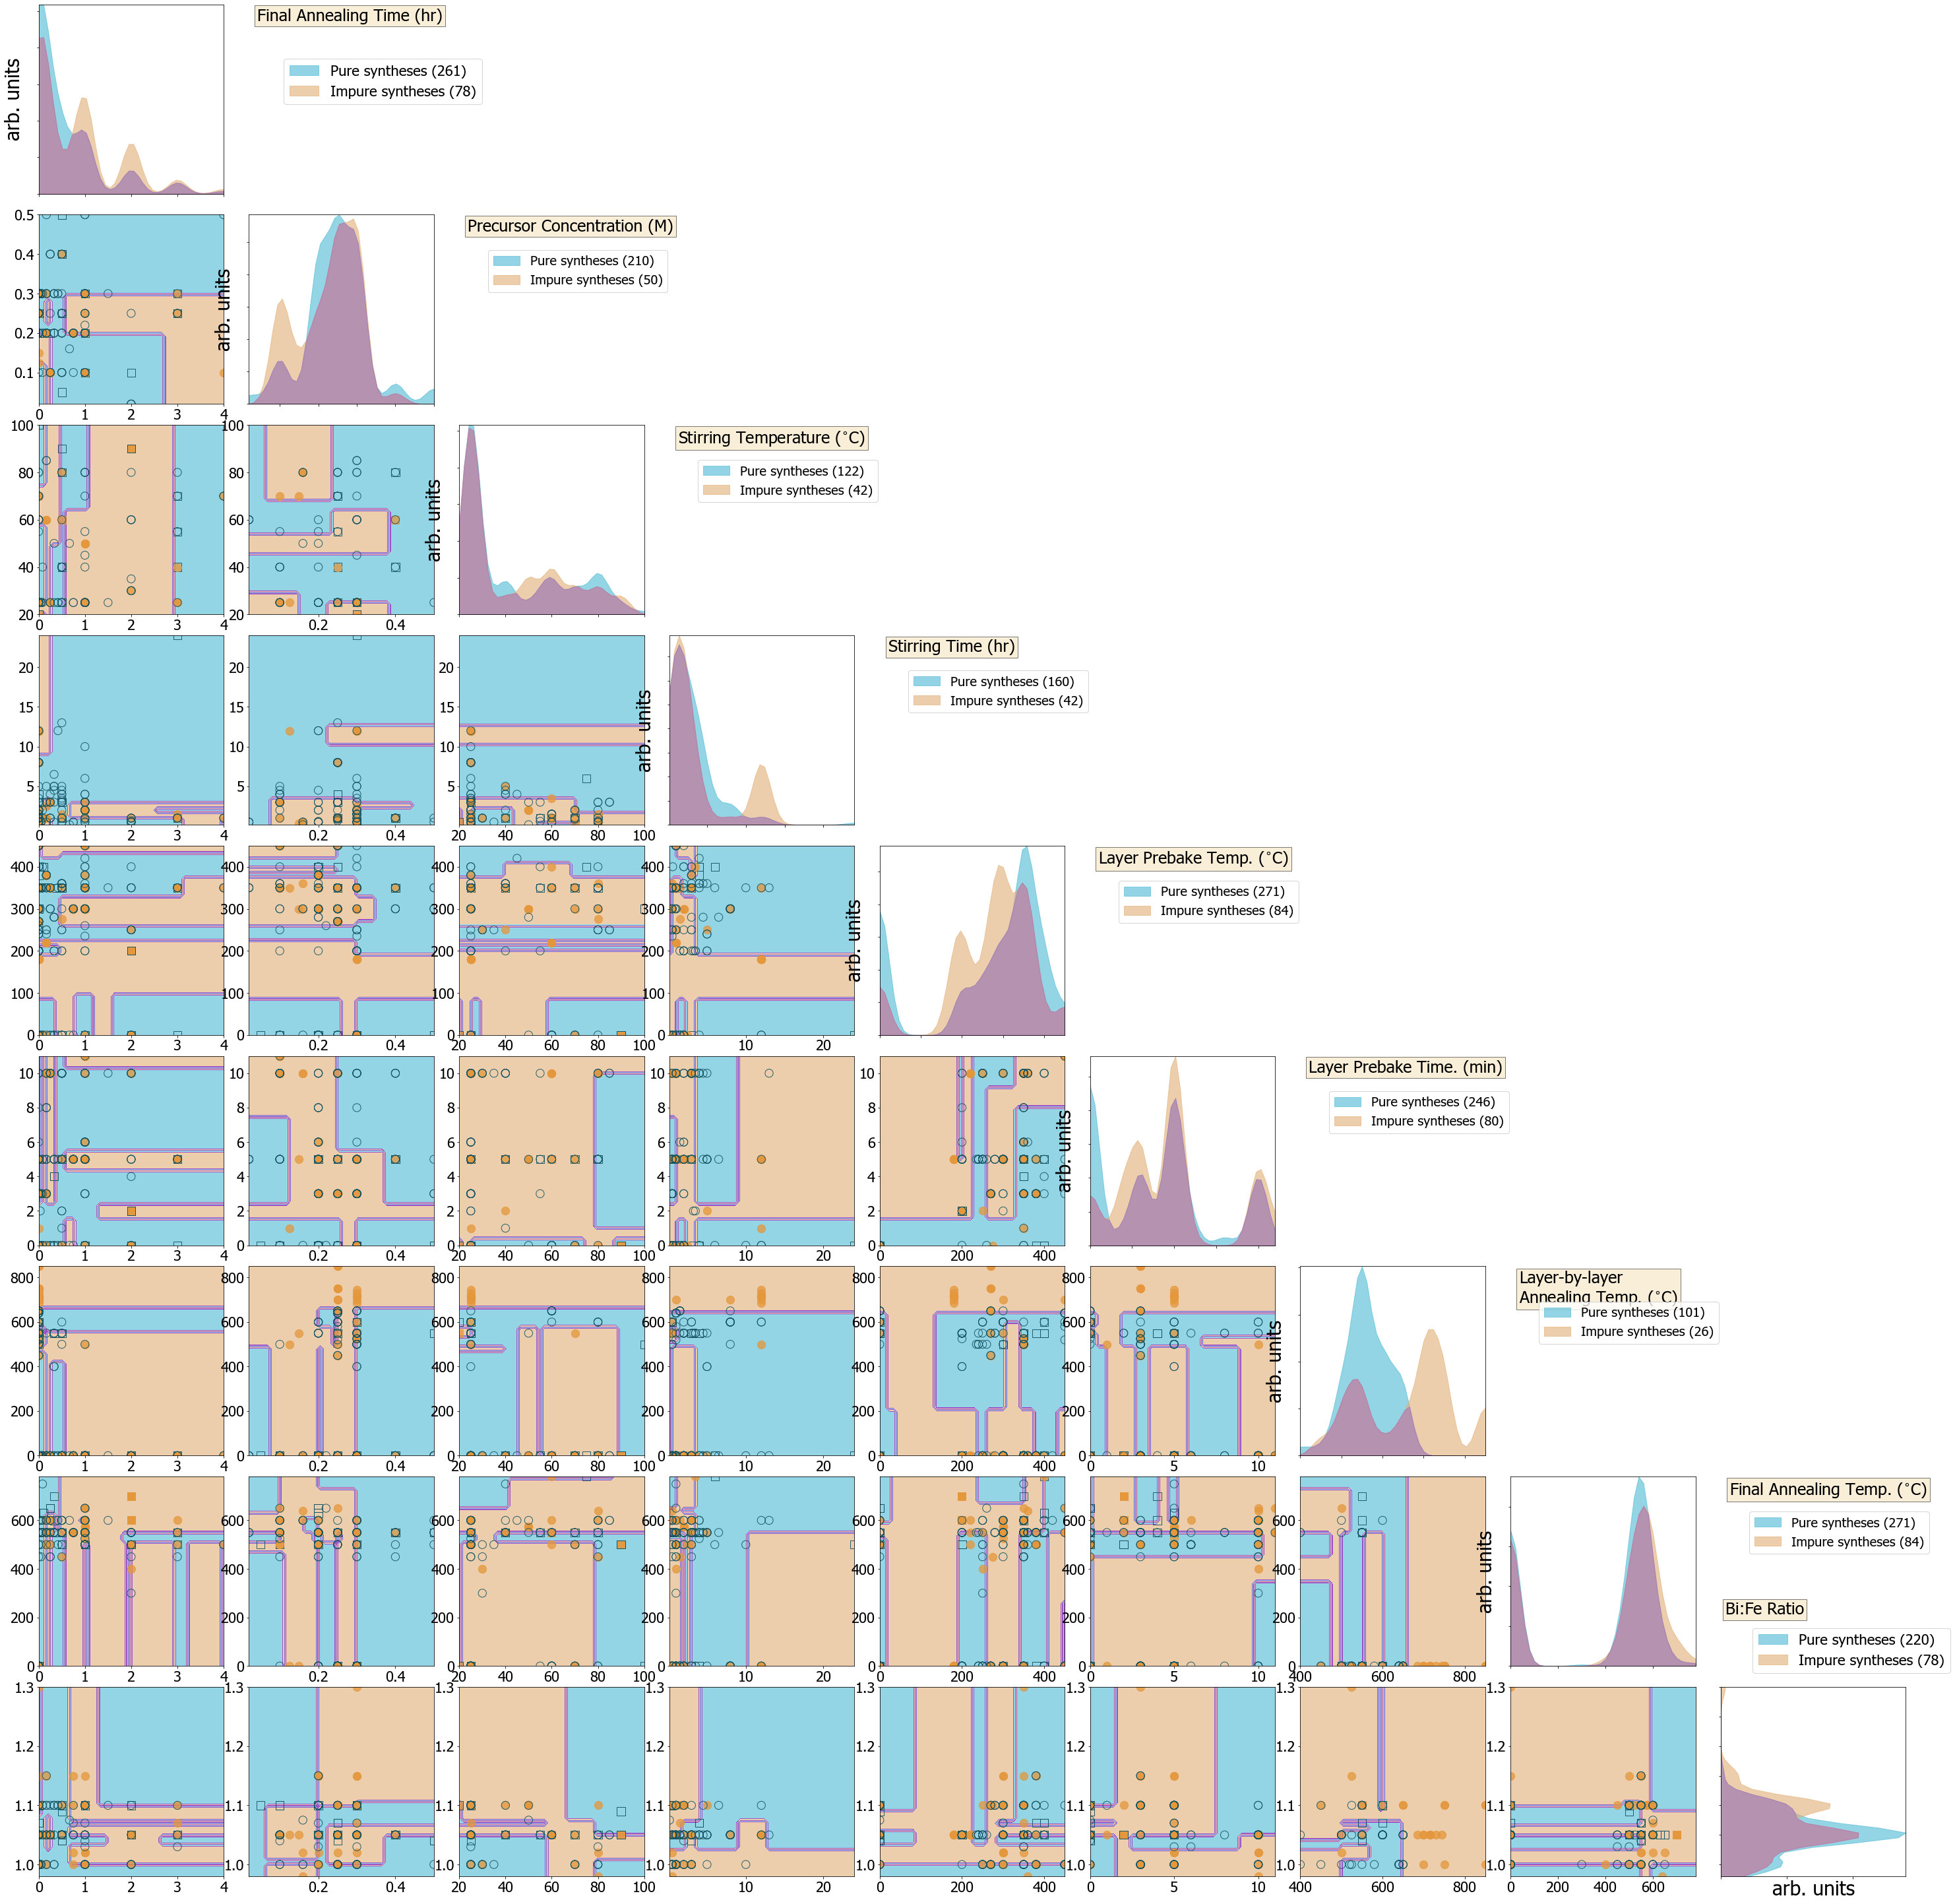

In [10]:
#codified_df = pd.read_csv('./data/bfo_df_codified_20211123.csv')
#refined_df = pd.read_csv('./data/bfo_df_codified_20211123.csv')

codified_df = pd.read_csv('./data/bfo_suggested_df_eda_20221019.csv')
refined_df = pd.read_csv('./data/bfo_suggested_df_eda_20221019.csv')

dec_df = pd.read_csv('./data/bfo_suggested_df_modeling_mmvi_20221019.csv')
dec_df = dec_df.fillna(0)
dec_labels = dec_df['impurity_code']

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

#set up pure and impure data series

params_of_interest = [
    'final_annealing_time_hr',
    'precursor_concentration',
    'stirring_temp_degC',
    'stirring_time_hr',
    'layer_prebake_degC',
    'layer_prebake_time_min',
    'layer_annealing_degC',
    'final_annealing_degC',
    'bi_fe_ratio'
]

labels = {
    'layer_annealing_degC' : 'Layer-by-layer\nAnnealing Temp. ($^{\circ}$C)',
    'final_annealing_degC' : 'Final Annealing Temp. ($^{\circ}$C)',
    'bi_fe_ratio' : 'Bi:Fe Ratio',
    'final_annealing_time_hr' : 'Final Annealing Time (hr)',
    'precursor_concentration' : 'Precursor Concentration (M)',
    'stirring_temp_degC' : 'Stirring Temperature ($^{\circ}$C)',
    'stirring_time_hr' : 'Stirring Time (hr)',
    'layer_prebake_degC' : 'Layer Prebake Temp. ($^{\circ}$C)',
    'layer_prebake_time_min' : 'Layer Prebake Time. (min)'
}

N = len(params_of_interest)

Fig, axs = plt.subplots(N, N, figsize=(40,40))
Fig.tight_layout()

for i, x_param in enumerate(params_of_interest):
    
    textstr = labels[x_param]
    
    #optionally, remove outliers
    if x_param in [
        'layer_prebake_time_min', 
        'layer_annealing_degC',
        'final_annealing_time_hr', 
        'stirring_temp_degC',
        'final_annealing_degC',
        'layer_prebake_degC']:
        x_max = np.Inf
        x_min = -np.Inf
        if x_param == 'layer_prebake_time_min':
            x_max = 20
        elif x_param == 'layer_annealing_degC':
            x_min = 1
        elif x_param == 'final_annealing_time_hr':
            x_max = 4
        elif x_param == 'stirring_temp_degC':
            x_max = 100
        codified_df[x_param] = codified_df[[x_param]].apply(
            lambda rec: None if rec[x_param]<x_min or rec[x_param]>x_max else rec[x_param],
            axis=1
        )
    
    x = codified_df[~codified_df[x_param].isnull()][['recipe_id', x_param]]
    x_pure_df = codified_df[(codified_df['impurity_code']==0) & (~codified_df[x_param].isnull())][['recipe_id', x_param]]
    x_impure_df = codified_df[(codified_df['impurity_code']==1) & (~codified_df[x_param].isnull())][['recipe_id', x_param]]
    x_pure = x_pure_df[x_param]
    x_impure = x_impure_df[x_param]
    
    x_pure_chel = codified_df[
        (codified_df['impurity_code']==0) &
        (~codified_df[x_param].isnull()) &
#         (codified_df['chem_pca-c21'] > 0.3)
        (codified_df[['citric_acid']].sum(axis=1))
    ][['recipe_id', x_param]]
    
    x_impure_chel = codified_df[
        (codified_df['impurity_code']==1) &
        (~codified_df[x_param].isnull()) &
#         (codified_df['chem_pca-c21'] > 0.3)
        (codified_df[['citric_acid']].sum(axis=1))
    ][['recipe_id', x_param]]
    
    joined_pure = x_pure_df.merge(
        x_pure_chel, 
        on=['recipe_id'],
        how='left',
        indicator=True
    )[['recipe_id', '{}_x'.format(x_param), '_merge']]
    
    
    joined_impure = x_impure_df.merge(
        x_impure_chel, 
        on=['recipe_id'],
        how='left',
        indicator=True
    )[['recipe_id', '{}_x'.format(x_param), '_merge']]
    
    x_pure_nochel = joined_pure[
        joined_pure['_merge'] == 'left_only'
    ].rename(columns={'{}_x'.format(x_param) : x_param})
    x_impure_nochel = joined_impure[
        joined_impure['_merge'] == 'left_only'
    ].rename(columns={'{}_x'.format(x_param) : x_param})
    
    assert(len(x_pure_nochel)+len(x_pure_chel)==len(x_pure))
    assert(len(x_impure_nochel)+len(x_impure_chel)==len(x_impure))
    
    x_min = min(min(x_pure), min(x_impure))
    x_max = max(max(x_pure), max(x_impure))
    
    xgrid = np.linspace(x_min, x_max, 40)
    
    pure_kde = KernelDensity(bandwidth=0.05*(x_max-x_min), kernel='gaussian')
    pure_kde.fit(np.asarray(x_pure).reshape(-1,1))
    pure_logprob = pure_kde.score_samples(xgrid.reshape(-1,1))
    
    impure_kde = KernelDensity(bandwidth=0.05*(x_max-x_min), kernel='gaussian')
    impure_kde.fit(np.asarray(x_impure).reshape(-1,1))
    impure_logprob = impure_kde.score_samples(xgrid.reshape(-1,1))
    
    ## comment from here to end if you only want binary distribution
    
    if i < len(params_of_interest)-1:
        axs[i,i].fill_between(xgrid, np.exp(pure_logprob), alpha=0.6, label="Pure syntheses ({})".format(len(x_pure)), color='#4bb9d4')
        axs[i,i].fill_between(xgrid, np.exp(impure_logprob), alpha=0.6, label="Impure syntheses ({})".format(len(x_impure)), color='#e2ae75')
        axs[i,i].fill_between(xgrid, np.minimum(np.exp(pure_logprob), np.exp(impure_logprob)), alpha=0.4, color='#9F52C8')
        axs[i,i].legend(loc='upper right', bbox_to_anchor=(2.3, 0.85), fontsize=20)
        axs[i,i].tick_params(axis='x', labelsize=16)
        axs[i,i].tick_params(axis='y', labelsize=16)
        # Uncomment here if you want binary dist as well
        axs[i,i].set_ylabel('arb. units', fontsize=30)
        axs[i,i].yaxis.set_label_coords(-0.08, 0.5)
        axs[i,i].tick_params(axis='both', which='both', labelbottom=False, labelleft=False)
        axs[i,i].margins(x=0, y=0)
        # end comment
        
        props = dict(facecolor='wheat', alpha=0.5)
        axs[i,i].text(1.1825, 0.98, textstr, transform=axs[i,i].transAxes, fontsize=25,
        verticalalignment='top', bbox=props)
    else:
        axs[i,i].fill_betweenx(xgrid, np.exp(pure_logprob), alpha=0.6, label="Pure syntheses ({})".format(len(x_pure)), color='#4bb9d4')
        axs[i,i].fill_betweenx(xgrid, np.exp(impure_logprob), alpha=0.6, label="Impure syntheses ({})".format(len(x_impure)), color='#e2ae75')
        axs[i,i].fill_betweenx(xgrid, np.minimum(np.exp(pure_logprob), np.exp(impure_logprob)), alpha=0.4, color='#9F52C8')
        axs[i,i].legend(loc='upper right', bbox_to_anchor=(2.3, 1.24), fontsize=20)
        axs[i,i].tick_params(axis='x', labelsize=16)
        axs[i,i].tick_params(axis='y', labelsize=16)
        axs[i,i].set_xlabel('arb. units', fontsize=20)
        # Uncomment here if you want binary dist as well
        axs[i,i].set_xlabel('arb. units', fontsize=30)
        axs[i,i].xaxis.set_label_coords(0.5, -0.02)
        axs[i,i].tick_params(axis='both', which='both', labelleft=False, labelbottom=False)
        axs[i,i].margins(x=0, y=0)
        # end comment
            
        props = dict(facecolor='wheat', alpha=0.5)
        axs[i,i].text(0.025, 1.45, textstr, transform=axs[i,i].transAxes, fontsize=25,
        verticalalignment='top', bbox=props)

    ## comment end
    
    for j, y_param in enumerate(params_of_interest):
        if j>i:
            #optionally, remove outliers
            if y_param in ['layer_prebake_time_min', 'final_annealing_time_hr', 'stirring_temp_degC']:
                if y_param == 'layer_prebake_time_min':
                    thresh = 20
                elif y_param == 'final_annealing_time_hr':
                    thresh = 4
                elif y_param == 'stirring_temp_degC':
                    thresh = 100
                codified_df[y_param] = codified_df[[y_param]].apply(
                    lambda rec: None if rec[y_param]>thresh else rec[y_param],
                    axis=1
                )
            y = codified_df[~codified_df[y_param].isnull()][y_param]

            idx = [idx for idx in list(x.index) if idx in list(y.index)]

            y_pure_df = codified_df[(codified_df['impurity_code']==0) & (~codified_df[y_param].isnull())]       
            
            y_impure_df = codified_df[(codified_df['impurity_code']==1) & (~codified_df[y_param].isnull())]
            
            y_pure = y_pure_df[y_param]
            y_impure = y_impure_df[y_param]

            y_pure_chel = codified_df[
                (codified_df['impurity_code']==0) &
                (~codified_df[y_param].isnull()) &
#                 (codified_df['chem_pca-c21'] > 0.3)
                (codified_df[['citric_acid']].sum(axis=1))
            ][['recipe_id', y_param]]

            y_impure_chel = codified_df[
                (codified_df['impurity_code']==1) &
                (~codified_df[y_param].isnull()) &
#                 (codified_df['chem_pca-c21'] > 0.3)
                (codified_df[['citric_acid']].sum(axis=1))
            ][['recipe_id', y_param]]

            joined_pure = y_pure_df.merge(
                y_pure_chel, 
                on=['recipe_id'],
                how='left',
                indicator=True
            )[['recipe_id', '{}_x'.format(y_param), '_merge']]


            joined_impure = y_impure_df.merge(
                y_impure_chel, 
                on=['recipe_id'],
                how='left',
                indicator=True
            )[['recipe_id', '{}_x'.format(y_param), '_merge']]

            y_pure_nochel = joined_pure[
                joined_pure['_merge'] == 'left_only'
            ].rename(columns={'{}_x'.format(y_param) : y_param})
            y_impure_nochel = joined_impure[
                joined_impure['_merge'] == 'left_only'
            ].rename(columns={'{}_x'.format(y_param) : y_param})
            
            pure_idx = [idx for idx in list(x_pure.index) if idx in list(y_pure.index)]
            pure_chel_idx = [rec_id for rec_id in x_pure_chel['recipe_id'].to_list() if rec_id in y_pure_chel['recipe_id'].to_list()]
            pure_nochel_idx = [rec_id for rec_id in x_pure_nochel['recipe_id'].to_list() if rec_id in y_pure_nochel['recipe_id'].to_list()]
            
            impure_idx = [idx for idx in x_impure.index if idx in y_impure.index]
            impure_chel_idx = [rec_id for rec_id in x_impure_chel['recipe_id'].to_list() if rec_id in y_impure_chel['recipe_id'].to_list()]
            impure_nochel_idx = [rec_id for rec_id in x_impure_nochel['recipe_id'].to_list() if rec_id in y_impure_nochel['recipe_id'].to_list()]

            pure_data = np.vstack([x_pure.loc[pure_idx],y_pure.loc[pure_idx]])
            impure_data = np.vstack([x_impure.loc[impure_idx],y_impure.loc[impure_idx]])
            
            y_min = min(min(y_pure), min(y_impure))
            y_max = max(max(y_pure), max(y_impure))
            
            ygrid = np.linspace(y_min, y_max, 40)

            Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
            
            pure_kde = gaussian_kde(pure_data)
            Z_pure = pure_kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

            try:
                impure_kde = gaussian_kde(impure_data)
                Z_impure = impure_kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
            except:
                print(x_param)
                print(y_param)
                print(impure_data)

            # Comment/uncomment here for KDE shading
#             pure_param_dist = axs[j,i].imshow(Z_pure.reshape(Xgrid.shape), 
#                        origin='lower',
#                        aspect='auto', 
#                        extent=[x_min, x_max, y_min, y_max],
#                        cmap="Blues",
#                        alpha=1)
            
#             impure_param_dist = axs[j,i].imshow(Z_impure.reshape(Xgrid.shape), 
#                        origin='lower',
#                        aspect='auto', 
#                        extent=[x_min, x_max, y_min, y_max],
#                        cmap="Reds",
#                        alpha=0.5)
            # end KDE shading
    
            # Comment/uncomment here for decision boundary shading

            # Todo: for some reason this sometimes gives different results for boundaries the same pair of conditions
            # Not sure why...
            
            pair_tree_df = dec_df.loc[:, [x_param, y_param]]
            X = pair_tree_df #df.loc[:, df.columns != 'impurity_code']
            y = dec_labels #df.loc[:, df.columns == 'impurity_code']
            over_sample = SMOTE(random_state=seed)
            X_train, test_features, y_train, test_labels = train_test_split(X, y, test_size=0.2, stratify=y, random_state=256)
            columns = X_train.columns

            os_data_X, os_data_y = over_sample.fit_resample(X_train, y_train)

            lit_train_features = os_data_X
            lit_train_labels = os_data_y

            lit_tree = DecisionTreeClassifier(
                criterion=criterion,
                splitter="best",
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=seed,
                max_features=None,
            )

            lit_tree.fit(lit_train_features, lit_train_labels)
            Z = lit_tree.predict(np.c_[Xgrid.ravel(), Ygrid.ravel()])
            Z = Z.reshape(Xgrid.shape)
            cont = axs[j, i].contourf(Xgrid, Ygrid, Z, colors=['#93d5e5', '#9F52C8', '#edceac', '#9F52C8'])#cmap=plt.cm.Pastel2)
            #plt.colorbar(cont)
            
            
            
            # end decision boundary shadings

            #imp_x = codified_df[codified_df['impurity_code']==1][x_param]
            #imp_y = codified_df[codified_df['impurity_code']==1][y_param]
            #pur_x = codified_df[codified_df['impurity_code']==0][x_param]
            #pur_y = codified_df[codified_df['impurity_code']==0][y_param]

            s = 150
            
            axs[j,i].scatter(x_impure_chel.loc[x_impure_chel['recipe_id'].isin(impure_chel_idx)][x_param], y_impure_chel.loc[y_impure_chel['recipe_id'].isin(impure_chel_idx)][y_param], c='#e4973b', alpha=0.75, s=s, marker='s')
            axs[j,i].scatter(x_pure_chel.loc[x_pure_chel['recipe_id'].isin(pure_chel_idx)][x_param], y_pure_chel.loc[y_pure_chel['recipe_id'].isin(pure_chel_idx)][y_param], facecolors='none', edgecolors='#155564', alpha=0.9, s=s, marker='s')

            axs[j,i].scatter(x_impure_nochel.loc[x_impure_nochel['recipe_id'].isin(impure_nochel_idx)][x_param], y_impure_nochel.loc[y_impure_nochel['recipe_id'].isin(impure_nochel_idx)][y_param], c='#e4973b', alpha=0.75, s=s)
            axs[j,i].scatter(x_pure_nochel.loc[x_pure_nochel['recipe_id'].isin(pure_nochel_idx)][x_param], y_pure_nochel.loc[y_pure_nochel['recipe_id'].isin(pure_nochel_idx)][y_param], facecolors='none', edgecolors='#155564', alpha=0.9, s=s)

            axs[j,i].tick_params(axis='x', labelsize=22)
            axs[j,i].tick_params(axis='y', labelsize=22)
            
            ## uncomment here if you also want unary distributions
            
#             if x_param == 'layer_annealing_degC':
#                 labels[x_param] = 'Layer Annealing Temp. ($^{\circ}$C)'
            
#             axs[j,i].set_xlabel(labels[x_param], fontsize=25, labelpad=10)
#             axs[j,i].set_ylabel(labels[y_param], fontsize=25, labelpad=20)
            
            ## end comment
            
            #QDA
#             X = pd.concat([refined_df[x_param], refined_df[y_param]], axis=1).to_numpy()
#             t = refined_df['impurity_code'].to_numpy()

#             qda = QDA()
#             qda.fit(X, t)
#             preds = qda.predict(X)

#             correct = 0
#             for true, pred in zip(t, preds):
#                 if true == pred:
#                     correct +=1 
                    
#             qda_accuracy = correct/len(t)
            
#             anchored_text = AnchoredText(
#                 "QDA accuracy: {0:.2f}".format(qda_accuracy), 
#                 loc='lower left', prop=dict(size=16), frameon=True,
#                        bbox_to_anchor=(0., 1.),
#                        bbox_transform=axs[j,i].transAxes
#             )
#             axs[j,i].add_artist(anchored_text)

        elif j!=i: #or j==i: # include extra boolean if you only want binary
            Fig.delaxes(axs[j,i])

axs[0,0].legend(loc='upper right', bbox_to_anchor=(2.435, 0.75), fontsize=22)
axs[-1,-1].legend(loc='upper right', bbox_to_anchor=(1.28, 1.35), fontsize=22)
plt.show()
#Fig.savefig('/Users/kevcruse96/Desktop/D2S2/TriennialReview/Presentation/annealtime_stirtemp_sugg.png', bbox_inches="tight")
#Fig.savefig('/Users/kevcruse96/Desktop/Qual/figures/BiFeO3/layeranneal_finalannealtime_sugg_decbound.png', bbox_inches="tight")
# Fig.savefig('/Users/kevcruse96/Desktop/D2S2/BiFeO3/tm_paper/figures/full_lit_decbound.png', bbox_inches="tight")
# Fig.savefig('/Users/kevcruse96/Desktop/D2S2/BiFeO3/tm_paper/figures/precconc_stirtemp_sugg_decbound.png', bbox_inches="tight")

# Full factorial

In [ ]:
with open('/Users/kevcruse96/PycharmProjects/bfo-impurityphase-analysis/models/20220524/saved_20220524_best_100_0.73.pkl', 'rb') as fp:
    saved_model = pickle.load(fp)

In [ ]:
saved_model.get_params()